**Доступ к данным**

**Импорт основных необходимых библиотек**




In [3]:
!pip install --upgrade pip
!pip3 install numpy pandas matplotlib seaborn xlrd xlwt mnist
!pip install scikit-learn keras 
!pip install tensorflow

Requirement already up-to-date: pip in c:\python27\lib\site-packages (20.3.4)


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import xlrd as xlrd
import openpyxl as openpyxl

ModuleNotFoundError: No module named 'tensorflow'

**Загрузка исходных датасетов**

In [ ]:
# считываем данные по металлу и сварке
steel_data = pd.read_excel('X_bp.xls')
welding_data = pd.read_excel('X_nup.xls')

# удалим столбцы с нумерацией
steel_data = steel_data.drop(steel_data.columns[0], axis = 1)
welding_data = welding_data.drop(welding_data.columns[0], axis = 1)

# объединяем два датафрейма 
dataframe = steel_data.join(welding_data, how='inner')

# очищаем датафрейм от колонок с пустыми значениями
df = dataframe.dropna()

df.to_excel('X_bp_nup.xls')

C:\Users\Alice\AppData\Local\Temp\ipykernel_29340\2333016457.py:15: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('X_bp_nup.xls')


In [ ]:
df.min() # поиск минимумов 
df.max() # поиск максимумов
df.info() # информация о признаках в таблице
df.isnull().sum() # проверка на пропуски
df.nunique() # число уникальных значений в датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки      

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

Все типы — float64

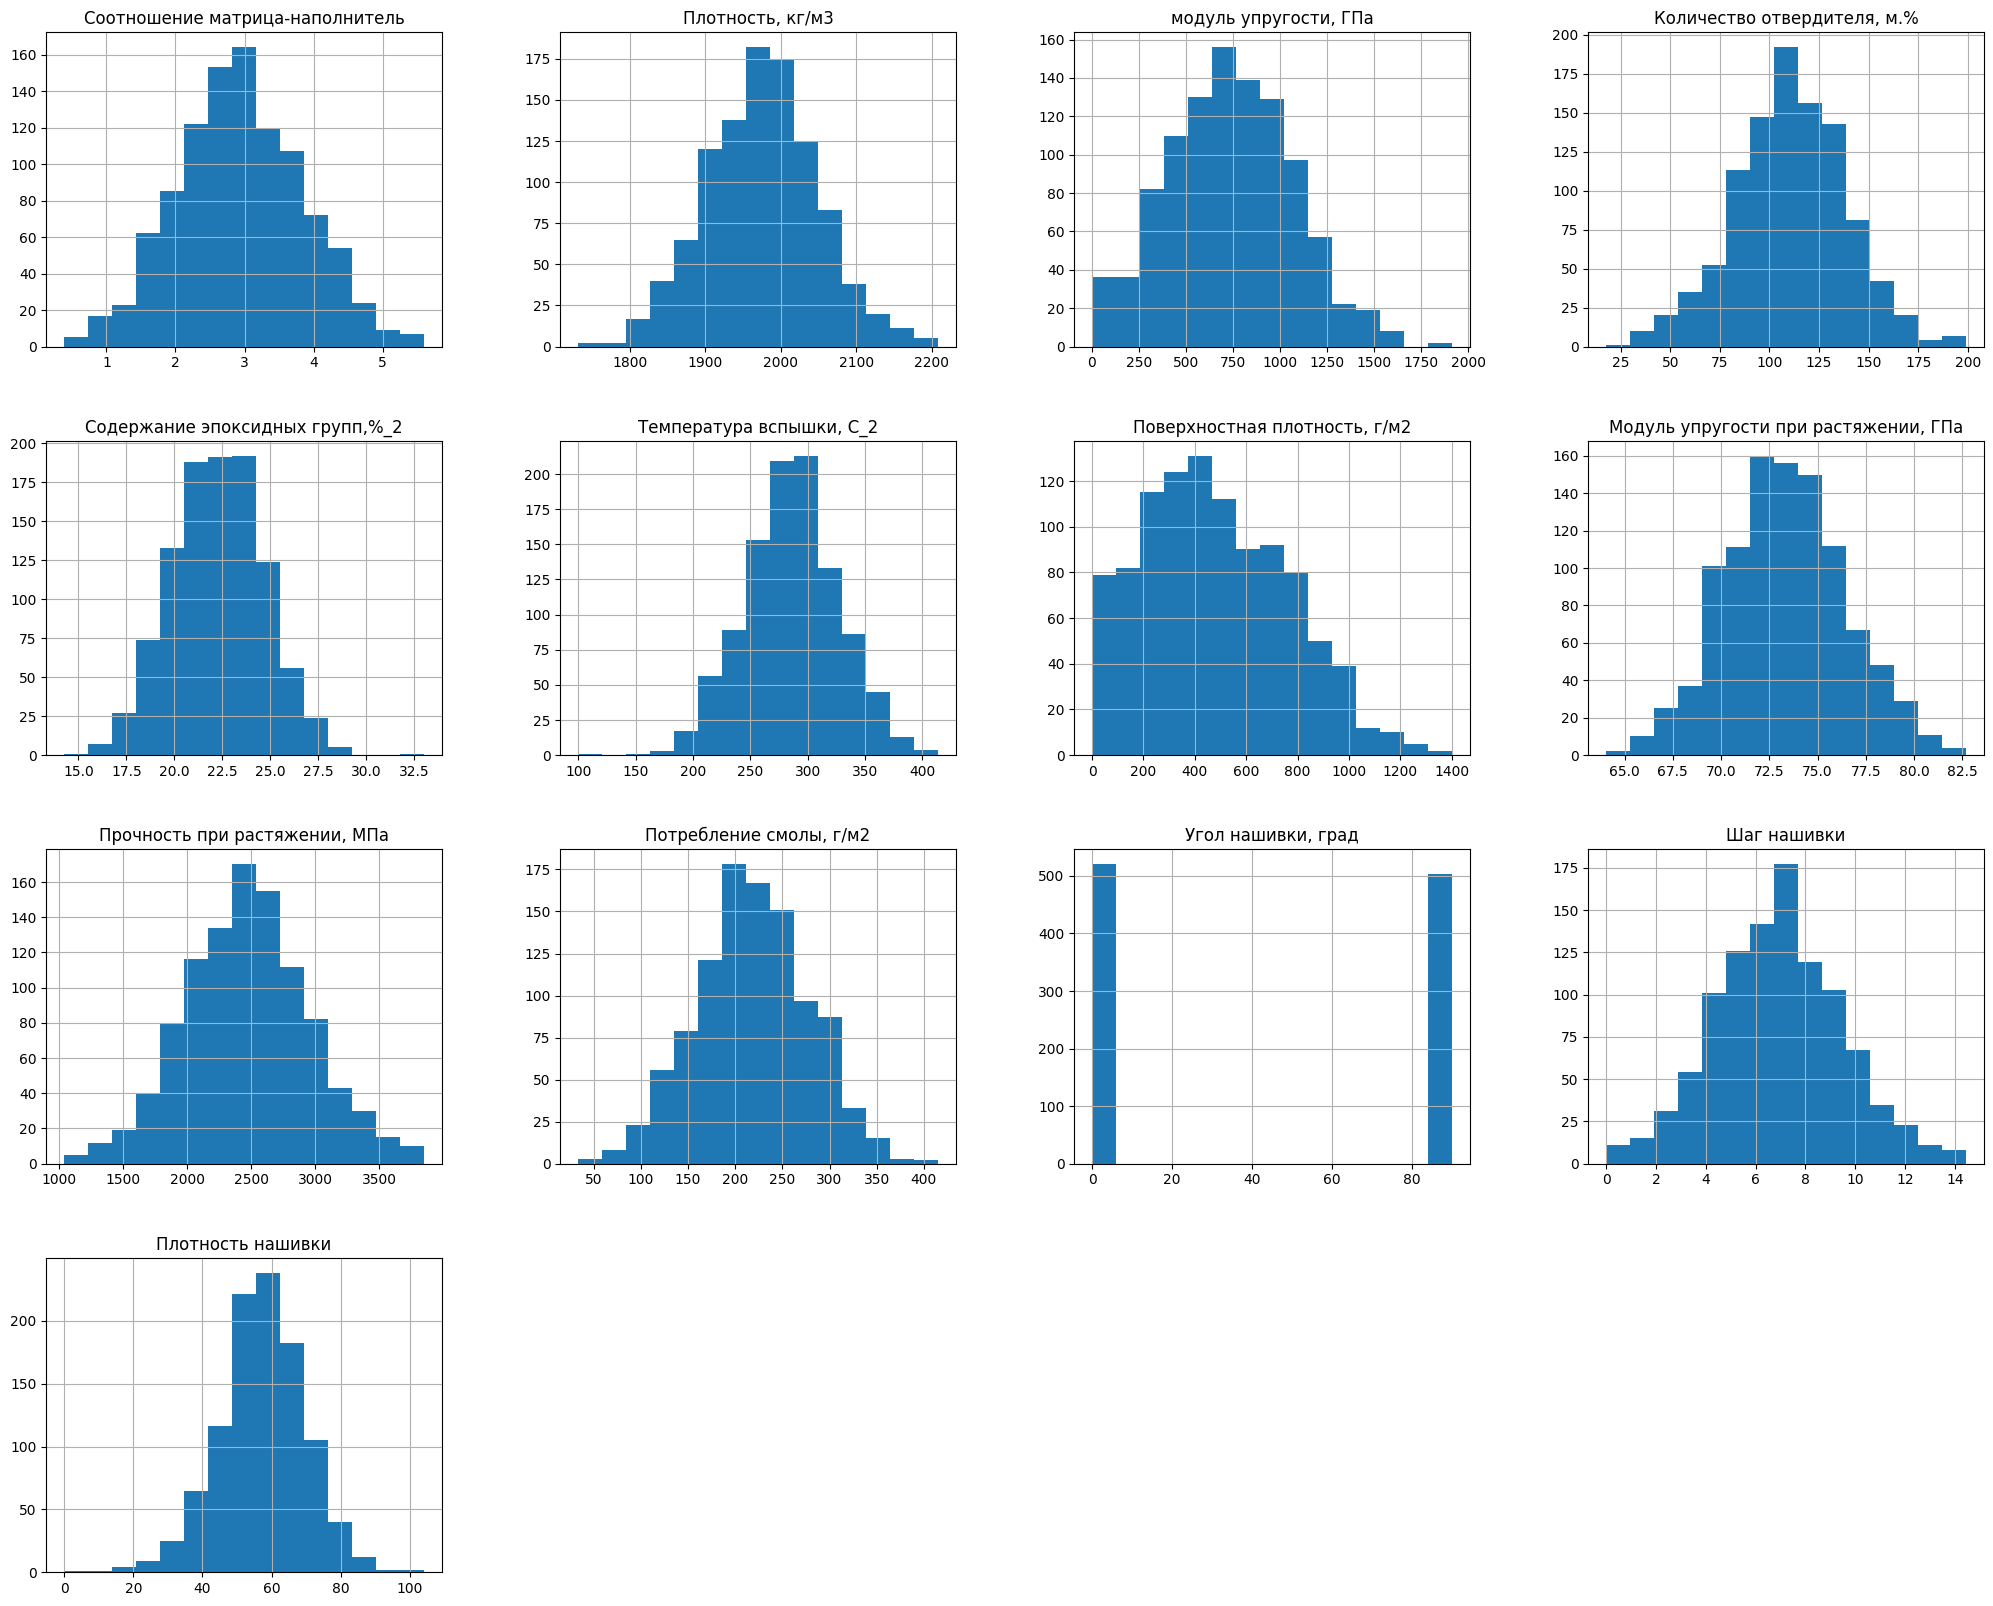

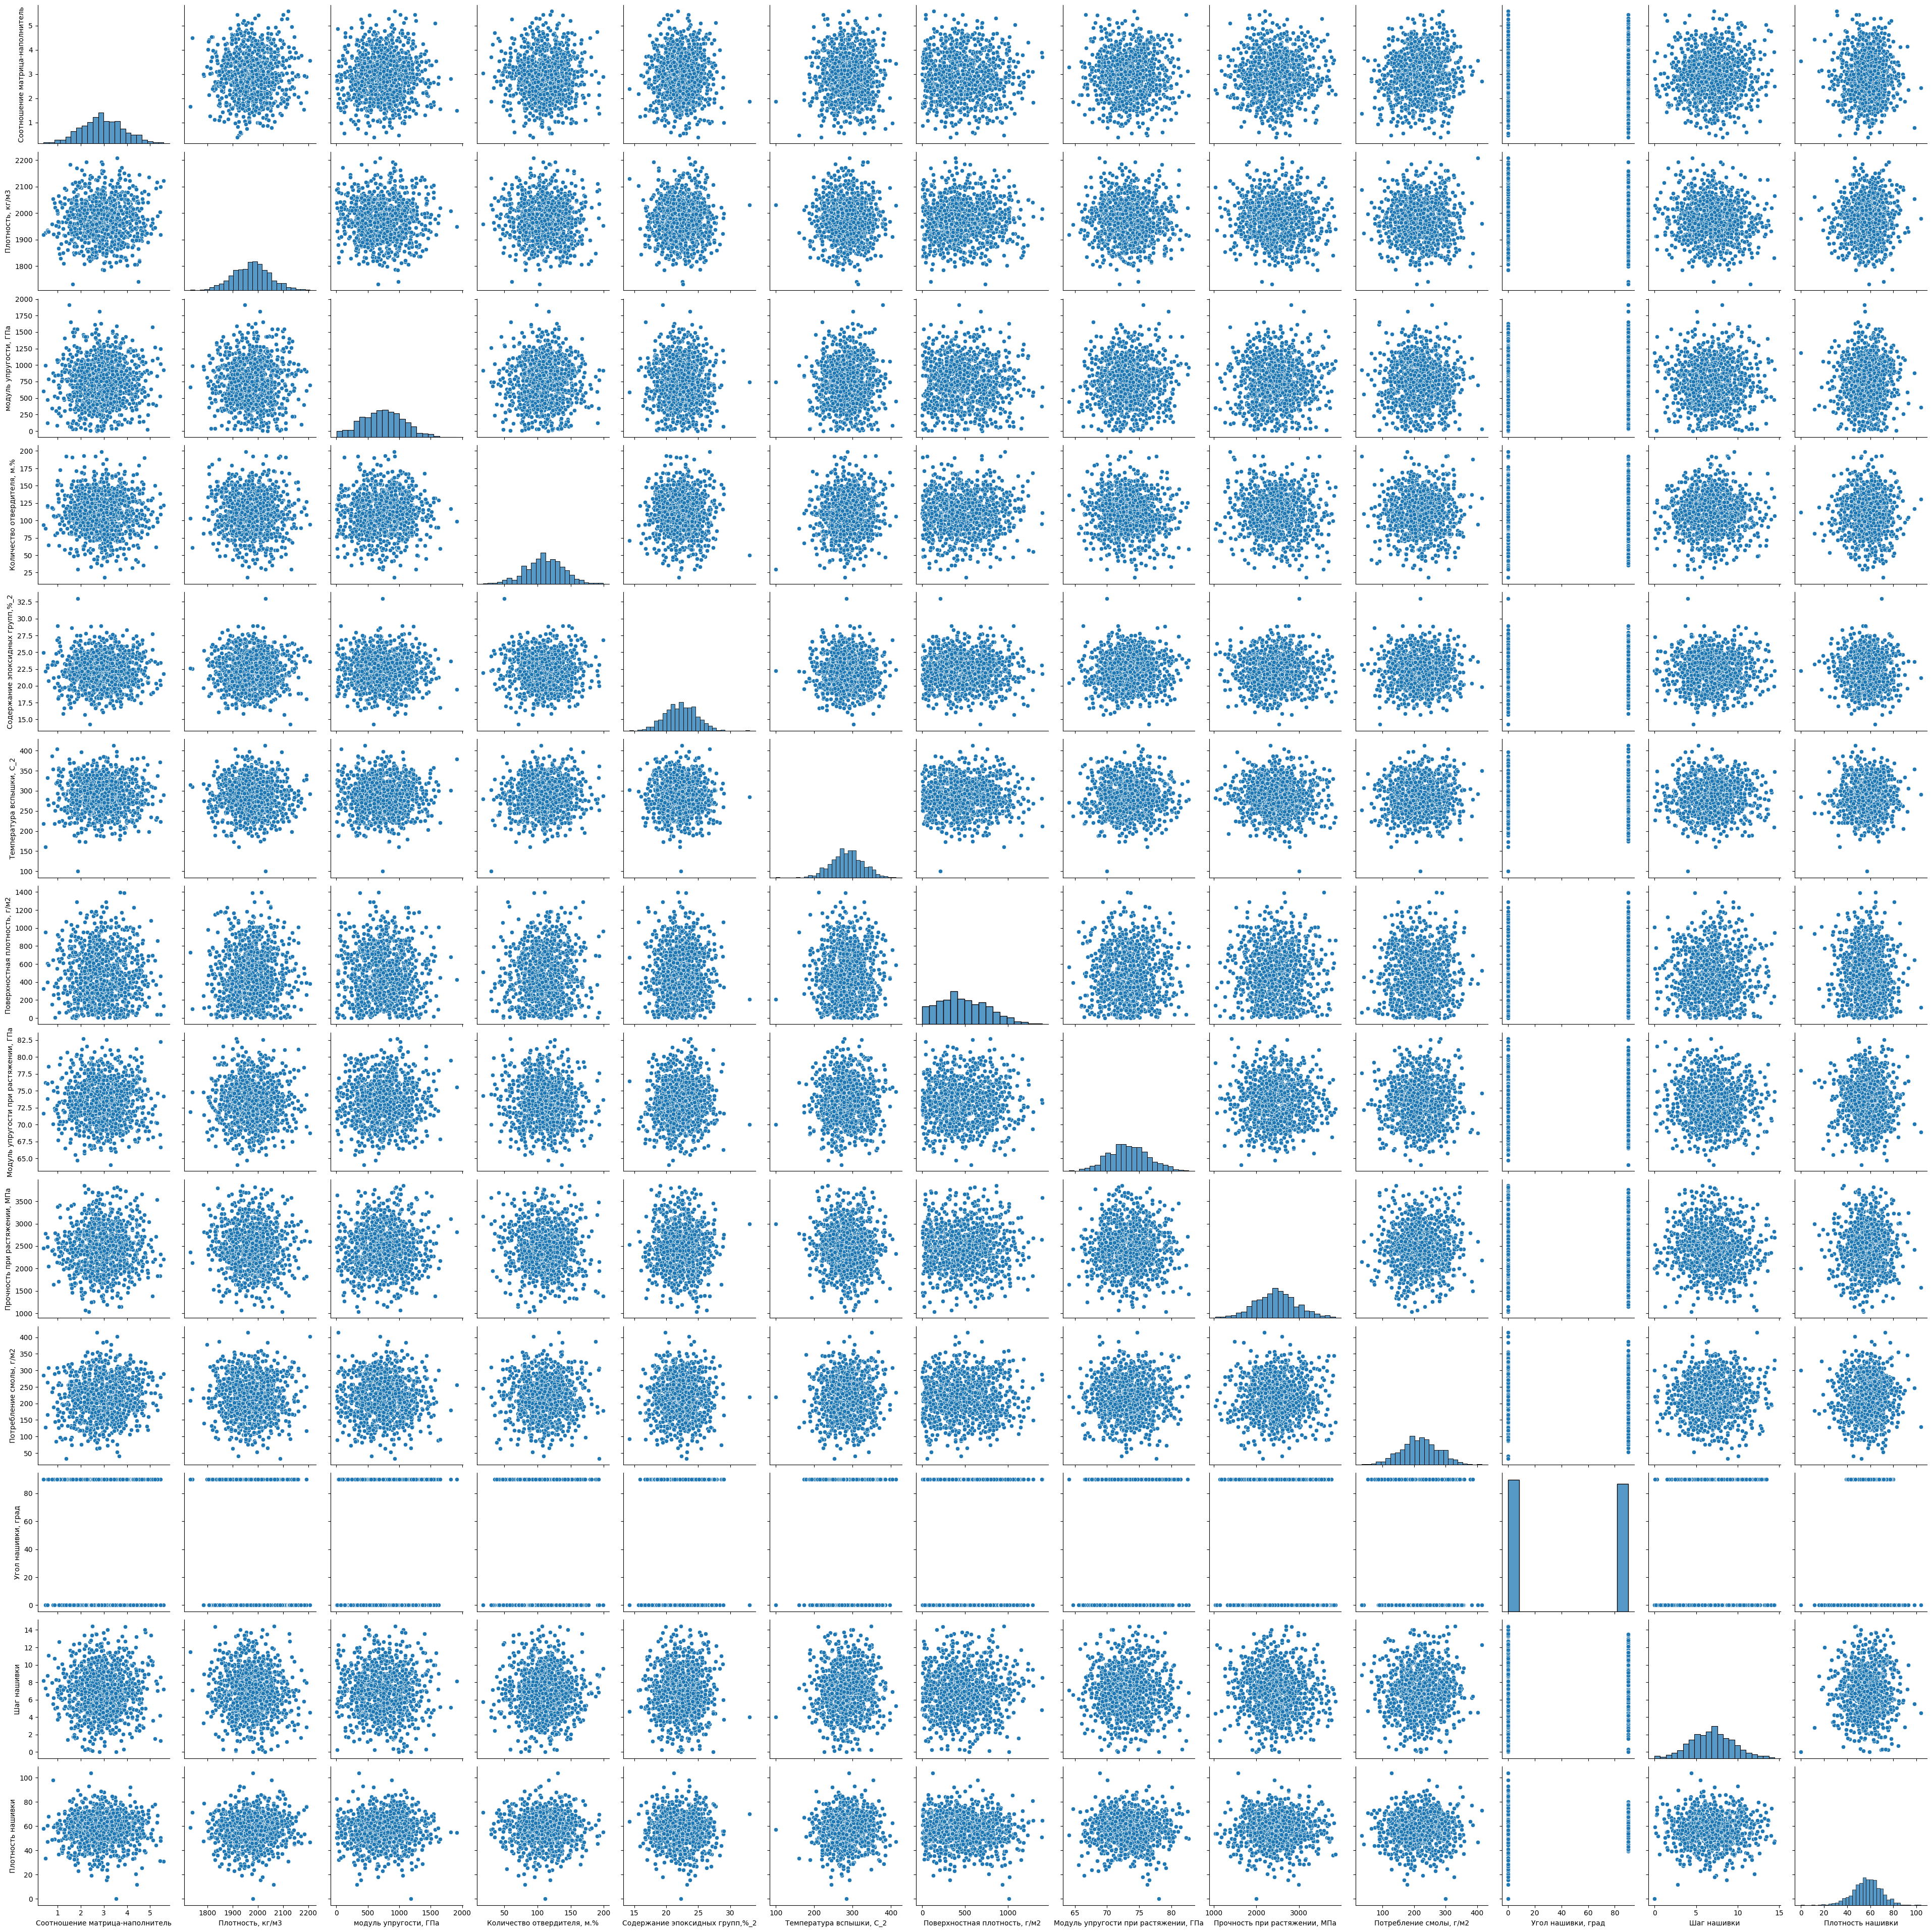

In [ ]:
# гистограммы распределения
df.hist(bins=15, figsize=(25, 20))

# рассеивание
sns.pairplot(df, height=3);

# ящики с усами
for k, column in enumerate(df.columns): 
    sns.boxplot(data=df, x=column, ax=axes[k, 1])

Поиск выбросов и их обработка

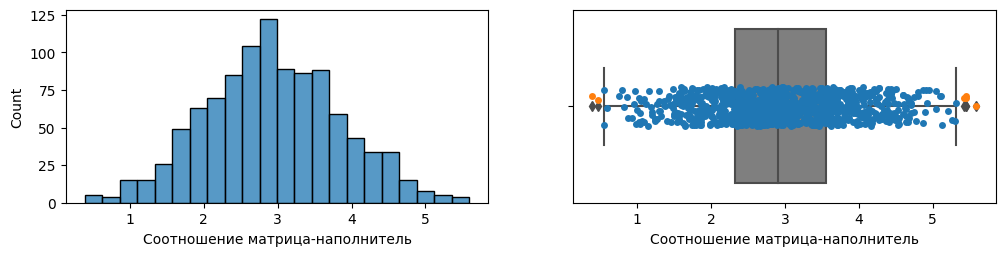

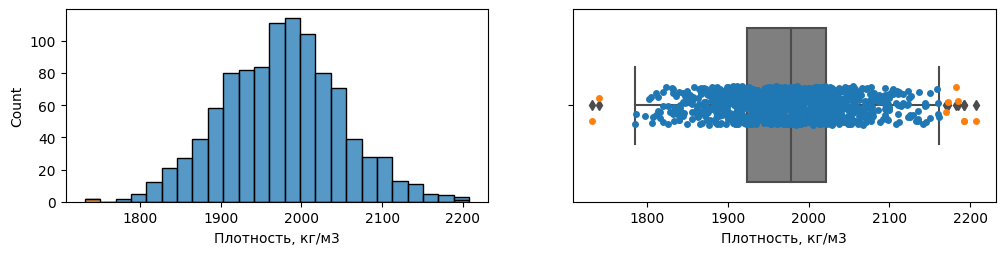

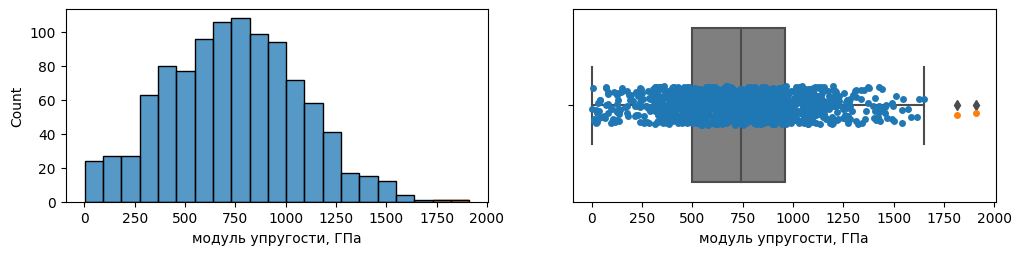

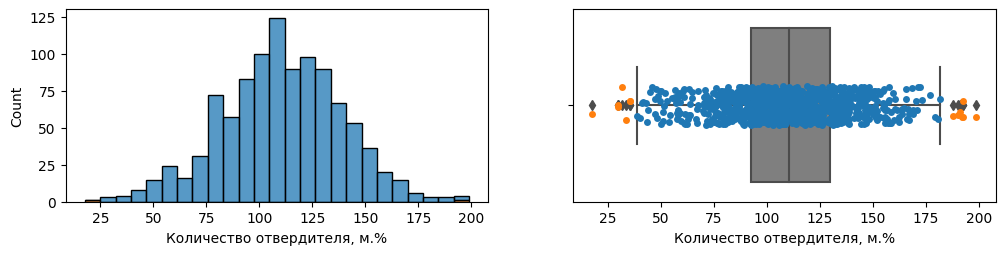

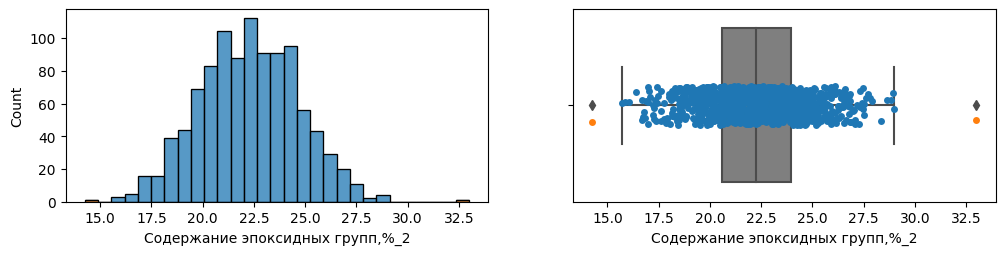

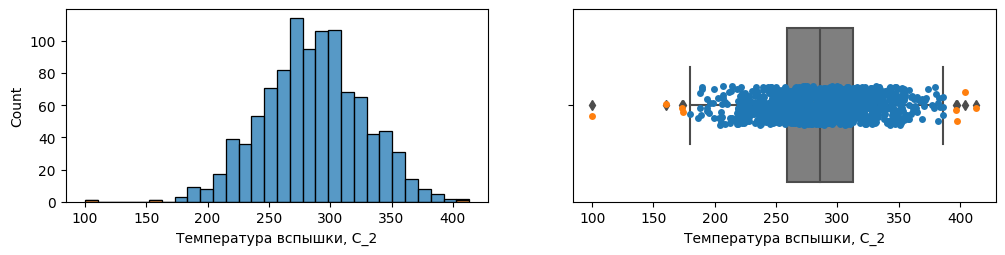

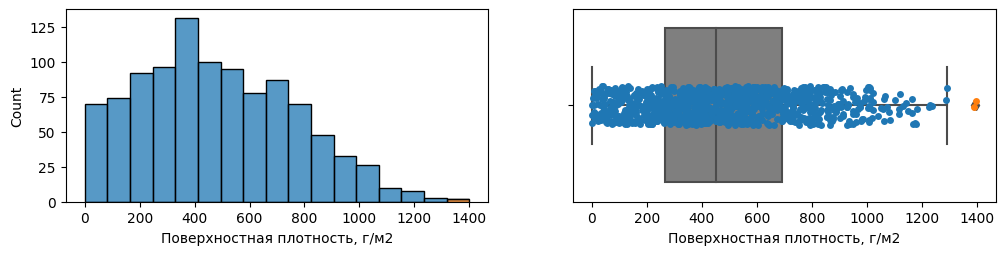

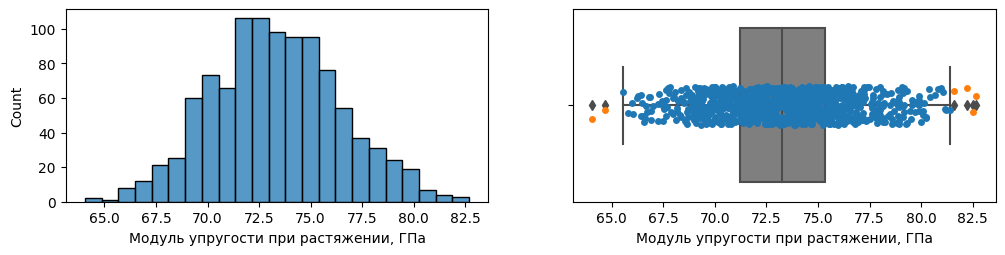

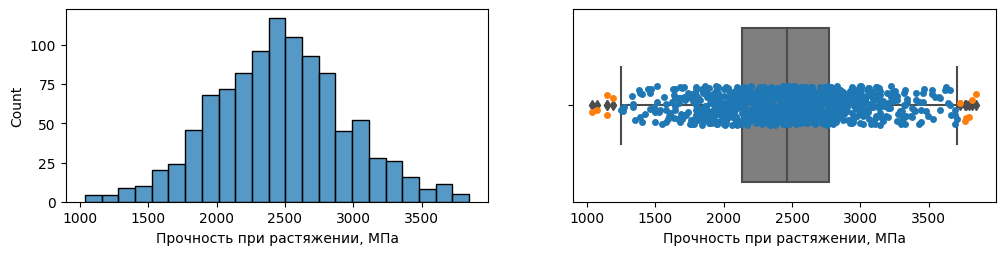

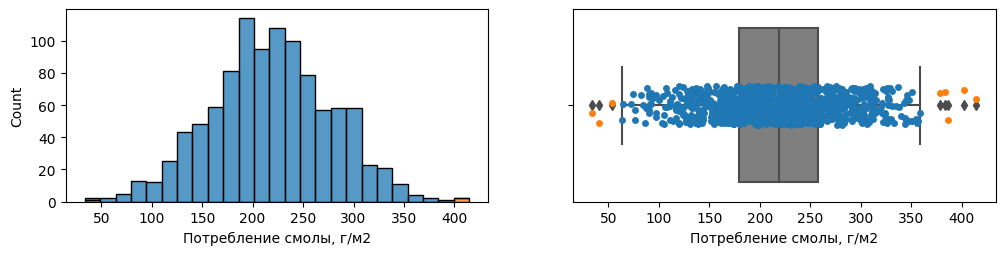

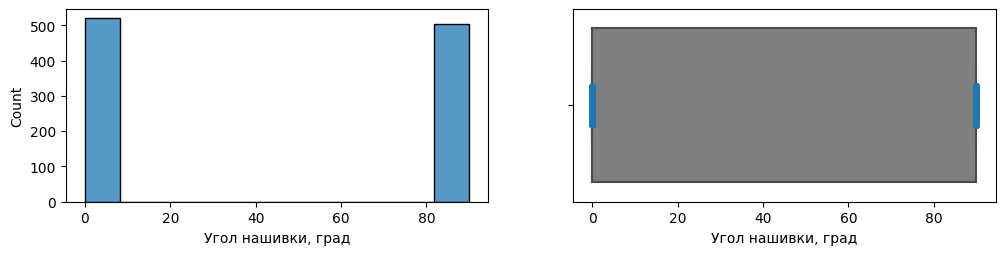

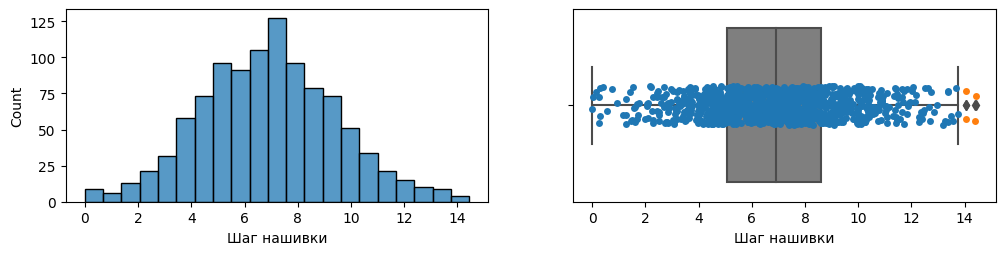

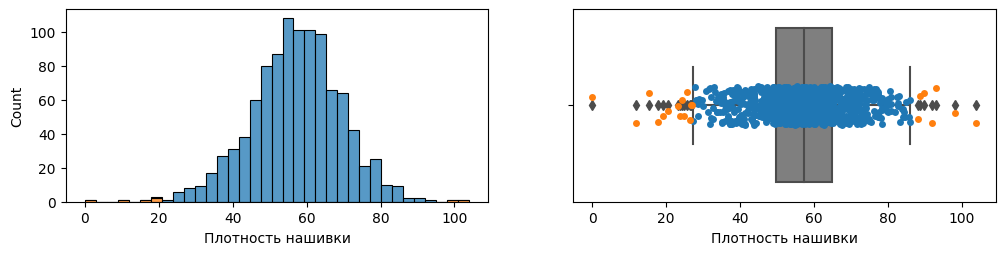

Выбросы по методу 3 сигм 24
Выбросы по методу межквартильных расстояний 93


In [ ]:
sum_3s = 0
sum_iq = 0

#поиск выбросов
for column in df:
    d = df.loc[:, [column]]
    # межквартильные расстояния
    quantile1 = np.quantile(df[column], 0.25)
    quantile3 = np.quantile(df[column], 0.75)
    iqr = quantile3 - quantile1
    lower = quantile1 - 1.5 * iqr
    upper = quantile3 + 1.5 * iqr
    d['iq'] = (df[column] <= lower) | (df[column] >= upper)
    sum_iq += d['iq'].sum()

    # 3 сигмы
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    sum_3s += d['3s'].sum()

    # визуализация выбросов
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))
    sns.histplot(data=d, x=column, hue='3s', multiple='stack', legend=False, ax=axes[0])
    sns.boxplot(data=d, x=column, color='tab:gray', ax=axes[1])
    sns.stripplot(data=d[d['iq']==False], x=column, ax=axes[1])
    sns.stripplot(data=d[d['iq']==True], x=column, color='tab:orange', ax=axes[1])
    plt.show()

print('Выбросы по методу 3 сигм', sum_3s)
print('Выбросы по методу межквартильных расстояний', sum_iq)

In [ ]:
vybr = pd.DataFrame(index=df.index)
for column in df:
    zscore = (df[column] - df[column].mean()) / df[column].std()
    vybr[column] = (zscore.abs() > 3)
df = df[vybr.sum(axis=1)==0]

df.to_excel=('df_clean.xls') # экспорт очищенных данных

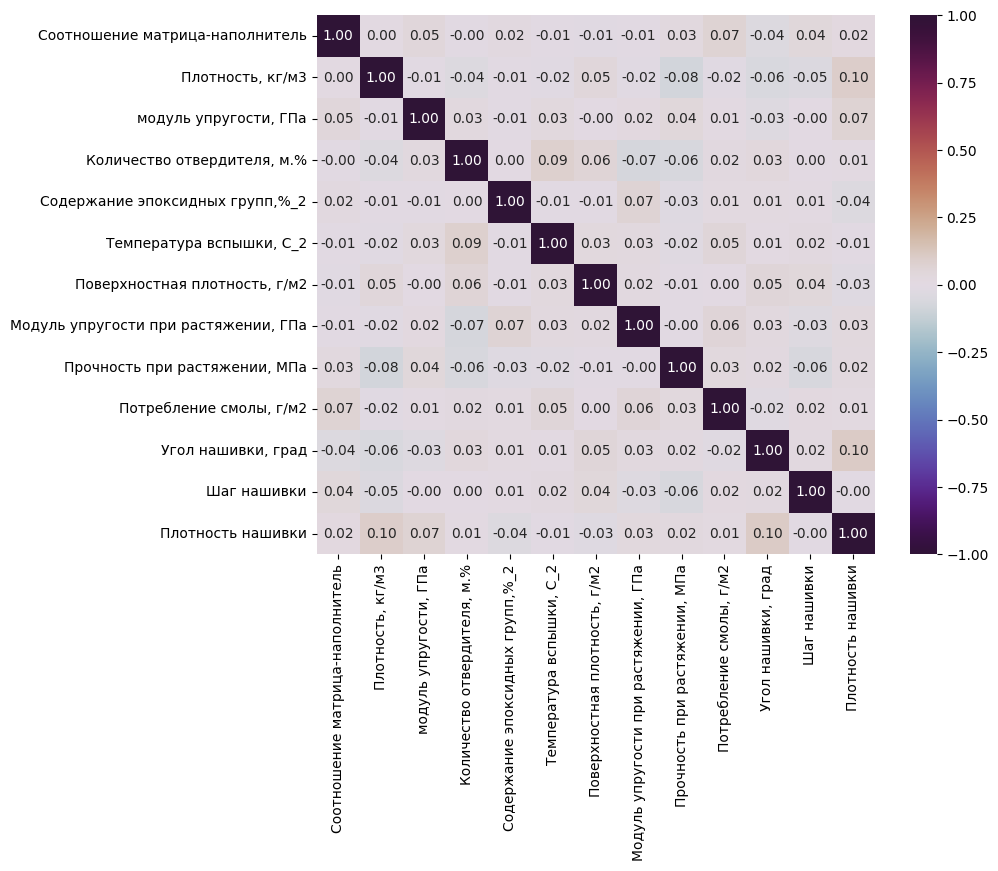

In [ ]:
corr = df.corr() # создаем матрицу корреляции
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='twilight_shifted', ax=ax)
plt.show()

**Модели для предсказания модуля упругости при растяжениии и прочности при растяжении, их обучение. Нейросеть для подготовки рекомендаций соотношения матрица-наполнитель**

In [ ]:
df = pd.read_excel('df_clean.xls', index_col=0)
df

NameError: name 'pd' is not defined

In [ ]:
y1_columns = ['Модуль упругости при растяжении, ГПа']
y2_columns = ['Прочность при растяжении, МПа']
x12_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

y1 = df.loc[:, y1_columns]
x1 = df.loc[:, x12_columns]

y2 = df.loc[:, y2_columns]
x2 = df.loc[:, x12_columns]

y3_columns = ['Соотношение матрица-наполнитель']
x3_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]
y3 = df.loc[:, y3_columns]
x3 = df.loc[:, x3_columns]

In [ ]:
x_qualitative = ['Угол нашивки, град']
x1_quantitative = [column for column in x1_columns if column not in x_qualitative]
x2_quantitative = [column for column in x2_columns if column not in x_qualitative]
x3_quantitative = [column for column in x3_columns if column not in x_qualitative]

In [ ]:
preproc1 = ColumnTransformer(transformers=[
        ("quantitative", StandardScaler(), x1_quantitative),
        ("qualitative", OrdinalEncoder(), x_qualitative)
])
preproc2 = ColumnTransformer(transformers=[
        ("quantitative", StandardScaler(), x2_quantitative),
        ("qualitative", OrdinalEncoder(), x_qualitative)
])
preproc3 = ColumnTransformer(transformers=[
        ("quantitative", StandardScaler(), x3_quantitative),
        ("qualitative", OrdinalEncoder(), x_qualitative)
])

Функции для упрощения дальнейшей работы

1) Поиск нужной модели

In [ ]:
def findmodels(models, x, y):
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=3128)
    scoring = [ 'r2', 
                'max_error', 
                'neg_root_mean_squared_error', 
                'neg_mean_absolute_error', 
                'neg_mean_absolute_percentage_error']
    for model_name, model in models.items():
        scores = cross_validate(model, x, y, cv=cv, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean()
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean()
        stat.loc[model_name, 'MAPE'] = scores['test_neg_mean_absolute_percentage_error'].mean()
        stat.loc[model_name, 'max_error'] = scores['test_max_error'].mean()
    return stat

Для каждой конкретной задачи зададим признаки:

In [ ]:
y3_col = ['Соотношение матрица-наполнитель']
x3_col = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

y3 = df.loc[:, y3_col]
x3 = df.loc[:, x3_col]

Препроцессинг

In [2]:
# Реализуем модель
model = Sequential()
model.add(Dense(128, input_dim=12, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
# Выходной слой
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

history = model.fit(X_train_scaled, y_train, validation_split=0.3, epochs = 30)

from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'Sequential' is not defined

In [ ]:
# проверяем работу модели
predictions = model.predict(X_test_scaled[:1])
print("Предсказанные значения", predictions)
print("Реальные значения", y_test[:1])

model.save('model_nn.h5')

In [ ]:
# делаем тестовую строку для получения параметра (Для нейронки). Но мы можем загрузить массив и так
import numpy as np
X_row_nn = X.iloc[145] 
# X_row
# print(X_row)
Y_row = y.iloc[145] 

In [ ]:
# получим данные для классических моделей
x1 = df.iloc[:,0:7]
y = df.iloc[:,7:9]
x2 = df.iloc[:,9:]
Xtrain_model = x1.join(x2)
Xtrain_model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain_model, y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from pickle import dump, load
scaler=StandardScaler()
scaler.fit(X_train)

dump(scaler, open('scaler.pkl', 'wb'))

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Модель линейной регрессии без гиперпараметров
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)

NameError: name 'X_train_scaled' is not defined

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
print(y_pred_tree)
mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)
print('Mean squared error using decision tree: ', mse_dt)
print('Mean absolute error using decision tree: ', mae_dt)